# Лабораторная работа №2: Семантическая сегментация

## Цель
Освоить методы семантической сегментации изображений на примере архитектур UNet и DeepLabv3+, изучить метрики качества (IoU, Dice).

## Теория
- Классификация vs. детекция vs. сегментация.
- Архитектура UNet и её особенности.
- DeepLabv3+ и dilated convolutions.
- Метрики: IoU, Dice.

## Задания
1. Выберите модель (UNet или DeepLabv3+).
2. Возьмите датасет (Carvana, Pascal VOC или Cityscapes subset).
3. Подготовьте данные и обучите модель сегментации.
4. Оцените качество с использованием IoU и Dice.
5. Визуализируйте результаты (картинки с наложением предсказанных масок).
6. Проведите эксперимент с разными размерами входного изображения или с аугментациями.

## Вопросы
1. Почему accuracy плохо отражает качество сегментации?
2. Чем UNet отличается от "обычной" CNN?

## Требуемое содержание файла проекта
- Иллюстрации входных изображений и масок.
- Примеры предсказаний модели.
- Сравнительный анализ экспериментов.
- Ответы на контрольные вопросы.

### 1. Почему accuracy плохо отражает качество сегментации?

**Accuracy** = `(TP + TN) / (TP + TN + FP + FN)` — доля правильно предсказанных *пикселей*.  
**Проблемы**:
- **Игнорирует дисбаланс классов**: при 95 % фона модель, всегда предсказывающая фон, получит 95 % accuracy, но **нулевую способность сегментировать объекты**.
- Не учитывает форму, связность и границы объектов.
- Одно и то же значение accuracy может соответствовать качественно разным маскам.

**Лучшие метрики для сегментации**:  
- **mIoU** (mean Intersection over Union) — основная метрика в Pascal VOC / Cityscapes  
- **Dice coefficient** — устойчива к дисбалансу, часто используется в медицинской сегментации (например, Carvana)  
- **Pixel Accuracy per class → mPA**

> В отчётах accuracy без mIoU/Dice считается недостаточной.


### 2. Чем UNet отличается от «обычной» CNN?

|                | Обычная CNN (VGG, ResNet) | UNet |
|----------------|---------------------------|------|
| **Задача**     | Классификация             | Плотное предсказание (сегментация) |
| **Выход**      | Вектор (1D)               | Карта масок (H×W×C) |
| **Структура**  | Encoder-only              | **Encoder–Decoder + skip-connections** |
| **Ключевая идея** | — | Конкатенация feature maps из encoder и decoder на одинаковых уровнях разрешения → сохранение пространственных деталей при восстановлении разрешения |

🔹 **Skip-connections** — главная особенность: позволяют точно восстанавливать границы, компенсируя потерю разрешения в пулингах.  
🔹 Благодаря им UNet эффективна даже при малом числе обучающих изображений (например, 500–1000 в Carvana).

> Именно эта архитектура легла в основу многих современных сегментационных моделей (например, DeepLabv3+ с UNet-декодером).

## Импорты

In [ ]:
# Установка необходимых библиотек и проверка GPU (Рекомендую запустить это окно только если лабораторная запускается в отрыве от 1 лабы
# так как в 1 лабе уже есть установка необходимых библиотек)

# 1. Удаляем текущие версии
!pip uninstall -y torch torchvision torchaudio ultralytics

# 2. Чистим кеш pip (важно!)
!pip cache purge

# 3. Устанавливаем PyTorch для CUDA 12.1
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu128

!pip install ultralytics torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu128
!pip install matplotlib seaborn pandas opencv-python tqdm

# Устанавливаем совместимые версии для CUDA 12.8 (cu128)
!pip install torch==2.9.1 torchvision==0.19.1 torchaudio==2.9.1 --index-url https://download.pytorch.org/whl/cu128
!pip install ultralytics==8.3.232 opencv-python matplotlib seaborn pandas tqdm pillow requests

In [1]:
!pip install segmentation-models-pytorch albumentations opencv-python-headless pillow -q
!pip install -q segmentation-models-pytorch albumentations opencv-python-headless matplotlib seaborn pandas tqdm pillow

In [17]:
# Импорт библиотек

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import os
import kagglehub

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# Настройка seed для воспроизводимости
torch.manual_seed(11)
np.random.seed(11)

device: cuda


In [18]:
# Проверка GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

print(f"PyTorch версия: {torch.__version__}")
print(f"Segmentation Models PyTorch версия: {smp.__version__}")
print(f"Albumentations версия: {A.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
print(f"Версия CUDA: {torch.version.cuda}")
print(f"Количество GPU: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")

Используемое устройство: cuda
PyTorch версия: 2.9.1+cu128
Segmentation Models PyTorch версия: 0.5.0
Albumentations версия: 2.0.8
CUDA доступна: True
Версия CUDA: 12.8
Количество GPU: 1
Имя GPU: NVIDIA GeForce RTX 4060 Ti


## 2. Загрузка и подготовка датасета carvana-image-masking-png

In [19]:
path = kagglehub.dataset_download("ipythonx/carvana-image-masking-png")
print(f"path to dataset: {path}")

# Пути к изображениям и маскам
TRAIN_IMG_DIR = os.path.join(path, "train_images")
TRAIN_MASK_DIR = os.path.join(path, "train_masks")

# Параметры датасета
IMG_SIZE = 256
NUM_CLASSES = 2  # Фон (0) и Автомобиль (1)
BATCH_SIZE = 4
NUM_WORKERS = 0

class CarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_ids, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_ids = img_ids
        self.transform = transform
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        # Загрузка изображения
        img_path = os.path.join(self.images_dir, img_id)
        image = np.array(Image.open(img_path).convert("RGB"))
        
        # Загрузка маски
        filename, _ = os.path.splitext(img_id)
        mask_name = filename + ".png"
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        
        # Маска в Carvana: 0 - фон, 255 - машина. Преобразуем в 0 и 1
        mask[mask == 255.0] = 1.0
        
        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image, mask.long()

# Получаем список файлов
sample_file = os.listdir(TRAIN_IMG_DIR)[0]
ext = os.path.splitext(sample_file)[1]
all_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith(ext)]
print(f"num all images: {len(all_files)}")

# Разделение на train/val (80/20)
val_size = int(len(all_files) * 0.2)
if val_size == 0 and len(all_files) > 0: val_size = 1 # Ensure at least 1 val sample
train_files = all_files[:-val_size]
val_files = all_files[-val_size:]

# Аугментации
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

# Создание датасетов
train_dataset = CarvanaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_files, transform=train_transform)
val_dataset = CarvanaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, val_files, transform=val_transform)

# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f'train size: {len(train_dataset)}')
print(f'val size: {len(val_dataset)}')
print(f'num batch in train: {len(train_loader)}')

path to dataset: C:\Users\krech\.cache\kagglehub\datasets\ipythonx\carvana-image-masking-png\versions\1
num all images: 5088
train size: 4071
val size: 1017
num batch in train: 1018


## Проверяем готовность датасета

**Это оказалось одной одной из самых трудоёмких задач, до этого пытался собрать на pascal-voc-2012, но там были ошибки с масками, поэтому подглядел этот датасет**
**Как итог, выбор датасета очень сильно влияет на объём проделанной работы, с подготовленными удобнее всего работать, а если брать со сторонних источников, часто**
**приходится менять структуру и изменять подход к работе с данными из датасета**

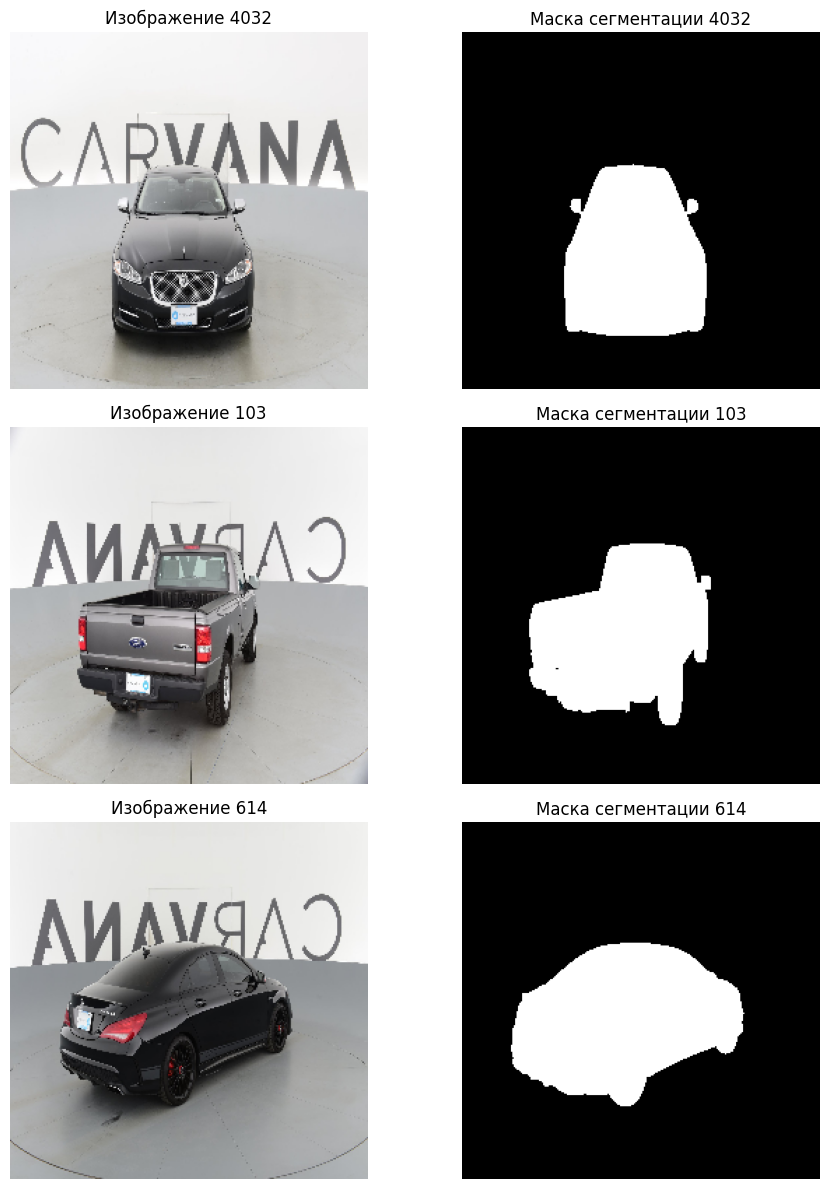

In [21]:
# Визуализация примеров из датасета
def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        image_np = image.numpy().transpose(1, 2, 0)
        image_np = np.clip(image_np, 0, 1)
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f'Изображение {idx}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.numpy(), cmap='gray')
        axes[i, 1].set_title(f'Маска сегментации {idx}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=3)

# 3. Реализация архитектуры UNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# В начало скрипта (после импортов)
torch.backends.cudnn.benchmark = True  # ускоряет свёртки при фиксированном размере входа
torch.backends.cudnn.deterministic = False  # жертвует детерминизмом ради скорости

# --- ОБЯЗАТЕЛЬНО УКАЖИТЕ DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Классы (остаются без изменений — они уже GPU-совместимы)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # Добавляем padding для точного выравнивания (если нужно)
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Пример: предположим NUM_CLASSES известен
NUM_CLASSES = 20  # ← ЗАМЕНИТЕ НА ФАКТИЧЕСКОЕ ЗНАЧЕНИЕ (например, из YAML)
model = UNet(in_channels=3, num_classes=NUM_CLASSES).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params: {total_params:,}, Trainable: {trainable_params:,}')

Using device: cuda
Total params: 31,044,756, Trainable: 31,044,756


# 4. Метрики качества: IoU и Dice

In [ ]:
def calculate_iou(pred, target, num_classes, smooth=1e-6):
    iou_list = []
    # Переводим на CPU для избежания накладных расходов (необязательно, но безопасно)
    # Либо работаем на GPU — тогда .item() обязателен (у нас уже есть)
    for cls in range(num_classes):
        pred_cls = (pred == cls)  # bool tensor на том же device
        target_cls = (target == cls)
        
        intersection = torch.logical_and(pred_cls, target_cls).sum(dtype=torch.float32)
        union = torch.logical_or(pred_cls, target_cls).sum(dtype=torch.float32)
        
        if union == 0:
            iou = torch.tensor(1.0, device=pred.device)
        else:
            iou = (intersection + smooth) / (union + smooth)
        
        iou_list.append(iou.item())  # ← безопасно даже на GPU
    
    return np.mean(iou_list), iou_list


def calculate_dice(pred, target, num_classes, smooth=1e-6):
    dice_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = torch.logical_and(pred_cls, target_cls).sum(dtype=torch.float32)
        pred_sum = pred_cls.sum(dtype=torch.float32)
        target_sum = target_cls.sum(dtype=torch.float32)
        
        if pred_sum + target_sum == 0:
            dice = torch.tensor(1.0, device=pred.device)
        else:
            dice = (2.0 * intersection + smooth) / (pred_sum + target_sum + smooth)
        
        dice_list.append(dice.item())
    
    return np.mean(dice_list), dice_list


def pixel_accuracy(pred, target):
    correct = (pred == target).sum(dtype=torch.float32)
    total = torch.numel(target)
    return (correct / total).item()

# 5. Обучение модели

In [32]:
# Параметры обучения
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [33]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    running_acc = 0.0
    
    pbar = tqdm(dataloader, desc='Обучение')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Метрики
        preds = torch.argmax(outputs, dim=1)
        iou, _ = calculate_iou(preds, masks, NUM_CLASSES)
        dice, _ = calculate_dice(preds, masks, NUM_CLASSES)
        acc = pixel_accuracy(preds, masks)
        
        running_loss += loss.item()
        running_iou += iou
        running_dice += dice
        running_acc += acc
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'IoU': f'{iou:.4f}',
            'Dice': f'{dice:.4f}'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    
    return epoch_loss, epoch_iou, epoch_dice, epoch_acc


def validate(model, dataloader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    running_acc = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Валидация'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            preds = torch.argmax(outputs, dim=1)
            iou, _ = calculate_iou(preds, masks, NUM_CLASSES)
            dice, _ = calculate_dice(preds, masks, NUM_CLASSES)
            acc = pixel_accuracy(preds, masks)
            
            running_loss += loss.item()
            running_iou += iou
            running_dice += dice
            running_acc += acc
    
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    
    return epoch_loss, epoch_iou, epoch_dice, epoch_acc

# 6. История обучения

In [34]:
# История обучения
history = {
    'train_loss': [], 'train_iou': [], 'train_dice': [], 'train_acc': [],
    'val_loss': [], 'val_iou': [], 'val_dice': [], 'val_acc': []
}

best_val_iou = 0.0


for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    # Обучение
    train_loss, train_iou, train_dice, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Валидация
    val_loss, val_iou, val_dice, val_acc = validate(
        model, val_loader, criterion, device
    )
    
    # Обновление learning rate
    scheduler.step(val_loss)
    
    # Сохранение истории
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_dice'].append(train_dice)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)
    history['val_acc'].append(val_acc)
    
    # Вывод результатов
    print(f'\nTrain   - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}, Acc: {train_acc:.4f}')
    print(f'Val  - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Acc: {val_acc:.4f}')
    
    # Сохранение лучшей модели
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), 'best_unet_model.pth')
        print(f'Model saved (IoU: {best_val_iou:.4f})')
    
    print()

print(f'\nTraining complete! Best IoU: {best_val_iou:.4f}')

Epoch 1/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:50<00:00,  5.08it/s]



Train   - Loss: 0.0366, IoU: 0.9959, Dice: 0.9979, Acc: 0.9859
Val  - Loss: 0.0249, IoU: 0.9971, Dice: 0.9985, Acc: 0.9902
Model saved (IoU: 0.9971)

Epoch 2/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:42<00:00,  6.04it/s]



Train   - Loss: 0.0228, IoU: 0.9974, Dice: 0.9987, Acc: 0.9912
Val  - Loss: 0.0161, IoU: 0.9982, Dice: 0.9991, Acc: 0.9937
Model saved (IoU: 0.9982)

Epoch 3/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:47<00:00,  5.35it/s]



Train   - Loss: 0.0177, IoU: 0.9979, Dice: 0.9989, Acc: 0.9930
Val  - Loss: 0.0543, IoU: 0.9950, Dice: 0.9974, Acc: 0.9819

Epoch 4/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:46<00:00,  5.44it/s]



Train   - Loss: 0.0187, IoU: 0.9978, Dice: 0.9989, Acc: 0.9927
Val  - Loss: 0.0134, IoU: 0.9985, Dice: 0.9992, Acc: 0.9948
Model saved (IoU: 0.9985)

Epoch 5/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:47<00:00,  5.34it/s]



Train   - Loss: 0.0161, IoU: 0.9981, Dice: 0.9990, Acc: 0.9936
Val  - Loss: 0.0134, IoU: 0.9984, Dice: 0.9992, Acc: 0.9947

Epoch 6/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:46<00:00,  5.52it/s]



Train   - Loss: 0.0157, IoU: 0.9982, Dice: 0.9991, Acc: 0.9938
Val  - Loss: 0.0152, IoU: 0.9983, Dice: 0.9991, Acc: 0.9942

Epoch 7/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:47<00:00,  5.42it/s]



Train   - Loss: 0.0145, IoU: 0.9983, Dice: 0.9991, Acc: 0.9942
Val  - Loss: 0.0108, IoU: 0.9987, Dice: 0.9993, Acc: 0.9956
Model saved (IoU: 0.9987)

Epoch 8/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:48<00:00,  5.22it/s]



Train   - Loss: 0.0122, IoU: 0.9985, Dice: 0.9993, Acc: 0.9950
Val  - Loss: 0.0816, IoU: 0.9920, Dice: 0.9957, Acc: 0.9697

Epoch 9/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:45<00:00,  5.58it/s]



Train   - Loss: 0.0131, IoU: 0.9984, Dice: 0.9992, Acc: 0.9947
Val  - Loss: 0.0107, IoU: 0.9987, Dice: 0.9993, Acc: 0.9956

Epoch 10/10
--------------------------------------------------


Валидация: 100%|██████████| 255/255 [00:46<00:00,  5.54it/s]


Train   - Loss: 0.0132, IoU: 0.9984, Dice: 0.9992, Acc: 0.9947
Val  - Loss: 0.0109, IoU: 0.9986, Dice: 0.9993, Acc: 0.9954


Training complete! Best IoU: 0.9987


# 7. Визуализация графиков

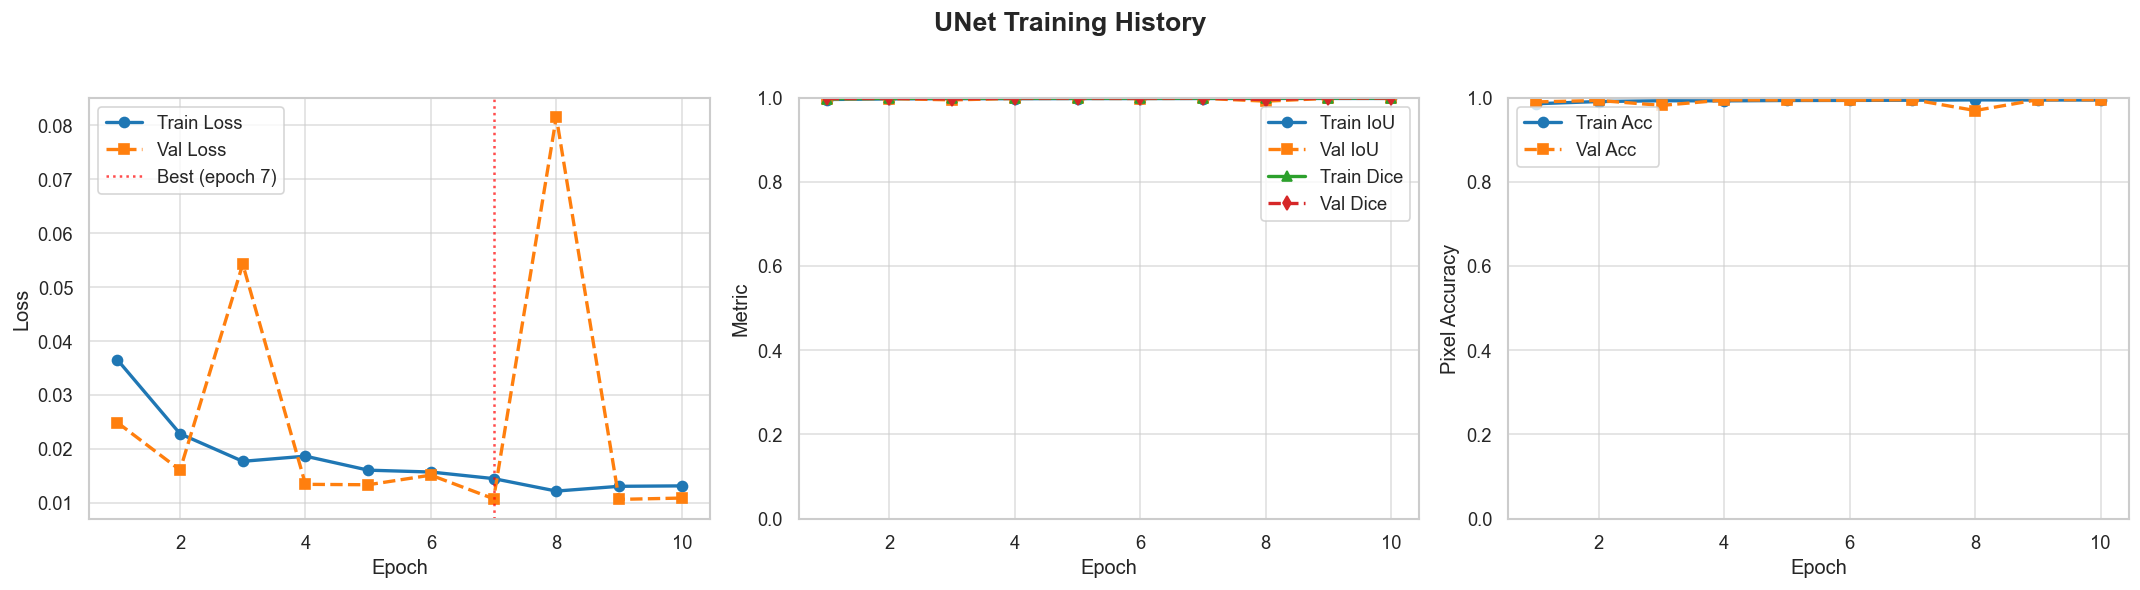

In [37]:
import seaborn as sns

# Настройка стиля
sns.set_theme(style="whitegrid", palette="tab10")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (14, 5),
    'figure.dpi': 120
})

def plot_training_history(history, num_epochs, best_epoch=None):
    epochs = range(1, num_epochs + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('UNet Training History', fontsize=16, fontweight='bold')

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 's--', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.6)
    if best_epoch:
        axes[0].axvline(best_epoch, color='red', linestyle=':', alpha=0.7, label=f'Best (epoch {best_epoch})')
        axes[0].legend()

    # IoU & Dice
    axes[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU', linewidth=2)
    axes[1].plot(epochs, history['val_iou'], 's--', label='Val IoU', linewidth=2)
    axes[1].plot(epochs, history['train_dice'], '^-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs, history['val_dice'], 'd--', label='Val Dice', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Metric')
    axes[1].set_ylim(0, 1)
    axes[1].legend()
    axes[1].grid(True, alpha=0.6)

    # Accuracy
    axes[2].plot(epochs, history['train_acc'], 'o-', label='Train Acc', linewidth=2)
    axes[2].plot(epochs, history['val_acc'], 's--', label='Val Acc', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Pixel Accuracy')
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    axes[2].grid(True, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Пример вызова (предполагается, что `history` и `best_val_iou_epoch` определены)
best_val_iou_epoch = np.argmax(history['val_iou']) + 1  # номер эпохи с лучшим IoU (1-based)
plot_training_history(history, NUM_EPOCHS, best_epoch=best_val_iou_epoch)

In [38]:
import torchvision.transforms.functional as F

def visualize_predictions(model, dataloader, device, class_names=None, num_samples=4):
    model.eval()
    
    images_list, masks_true_list, masks_pred_list = [], [], []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Берём первые `num_samples` из батча
            for i in range(min(num_samples, len(images))):
                images_list.append(images[i].cpu())
                masks_true_list.append(masks[i].cpu())
                masks_pred_list.append(preds[i].cpu())
                if len(images_list) >= num_samples:
                    break
            if len(images_list) >= num_samples:
                break
    
    # Подготавливаем классовые цвета (палитра)
    if class_names is None:
        class_names = [f"Class {i}" for i in range(NUM_CLASSES)]
    
    # Генерируем цветовую палитру (фиксированную для воспроизводимости)
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(NUM_CLASSES, 3)) / 255.0
    colors[0] = [0, 0, 0]  # фон — чёрный
    
    def colorize_mask(mask):
        h, w = mask.shape
        rgb = np.zeros((h, w, 3))
        for cls in range(NUM_CLASSES):
            rgb[mask == cls] = colors[cls]
        return rgb

    # Визуализация
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # для совместимости
    
    for i in range(num_samples):
        img = F.to_pil_image(images_list[i])
        mask_true = masks_true_list[i].numpy()
        mask_pred = masks_pred_list[i].numpy()
        
        # Исходное изображение
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image", fontweight='bold')
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(colorize_mask(mask_true))
        axes[i, 1].set_title("Ground Truth", fontweight='bold')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(colorize_mask(mask_pred))
        axes[i, 2].set_title("Prediction", fontweight='bold')
        axes[i, 2].axis('off')
        
        # Overlay (prediction поверх изображения, с прозрачностью)
        overlay = np.array(img) * 0.6 + colorize_mask(mask_pred) * 0.4 * 255
        axes[i, 3].imshow(overlay.astype(np.uint8))
        axes[i, 3].set_title("Overlay (Pred)", fontweight='bold')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Qualitative Results: Input → GT → Pred → Overlay", y=1.02, fontsize=16, fontweight='bold')
    plt.show()

    # Отображение легенды
    if NUM_CLASSES <= 10:  # не слишком много классов
        fig_legend, ax = plt.subplots(figsize=(6, 1.5))
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(NUM_CLASSES)]
        ax.legend(handles, class_names, loc='center', ncol=min(NUM_CLASSES, 5), frameon=True)
        ax.axis('off')
        plt.title("Class Legend", fontweight='bold')
        plt.show()

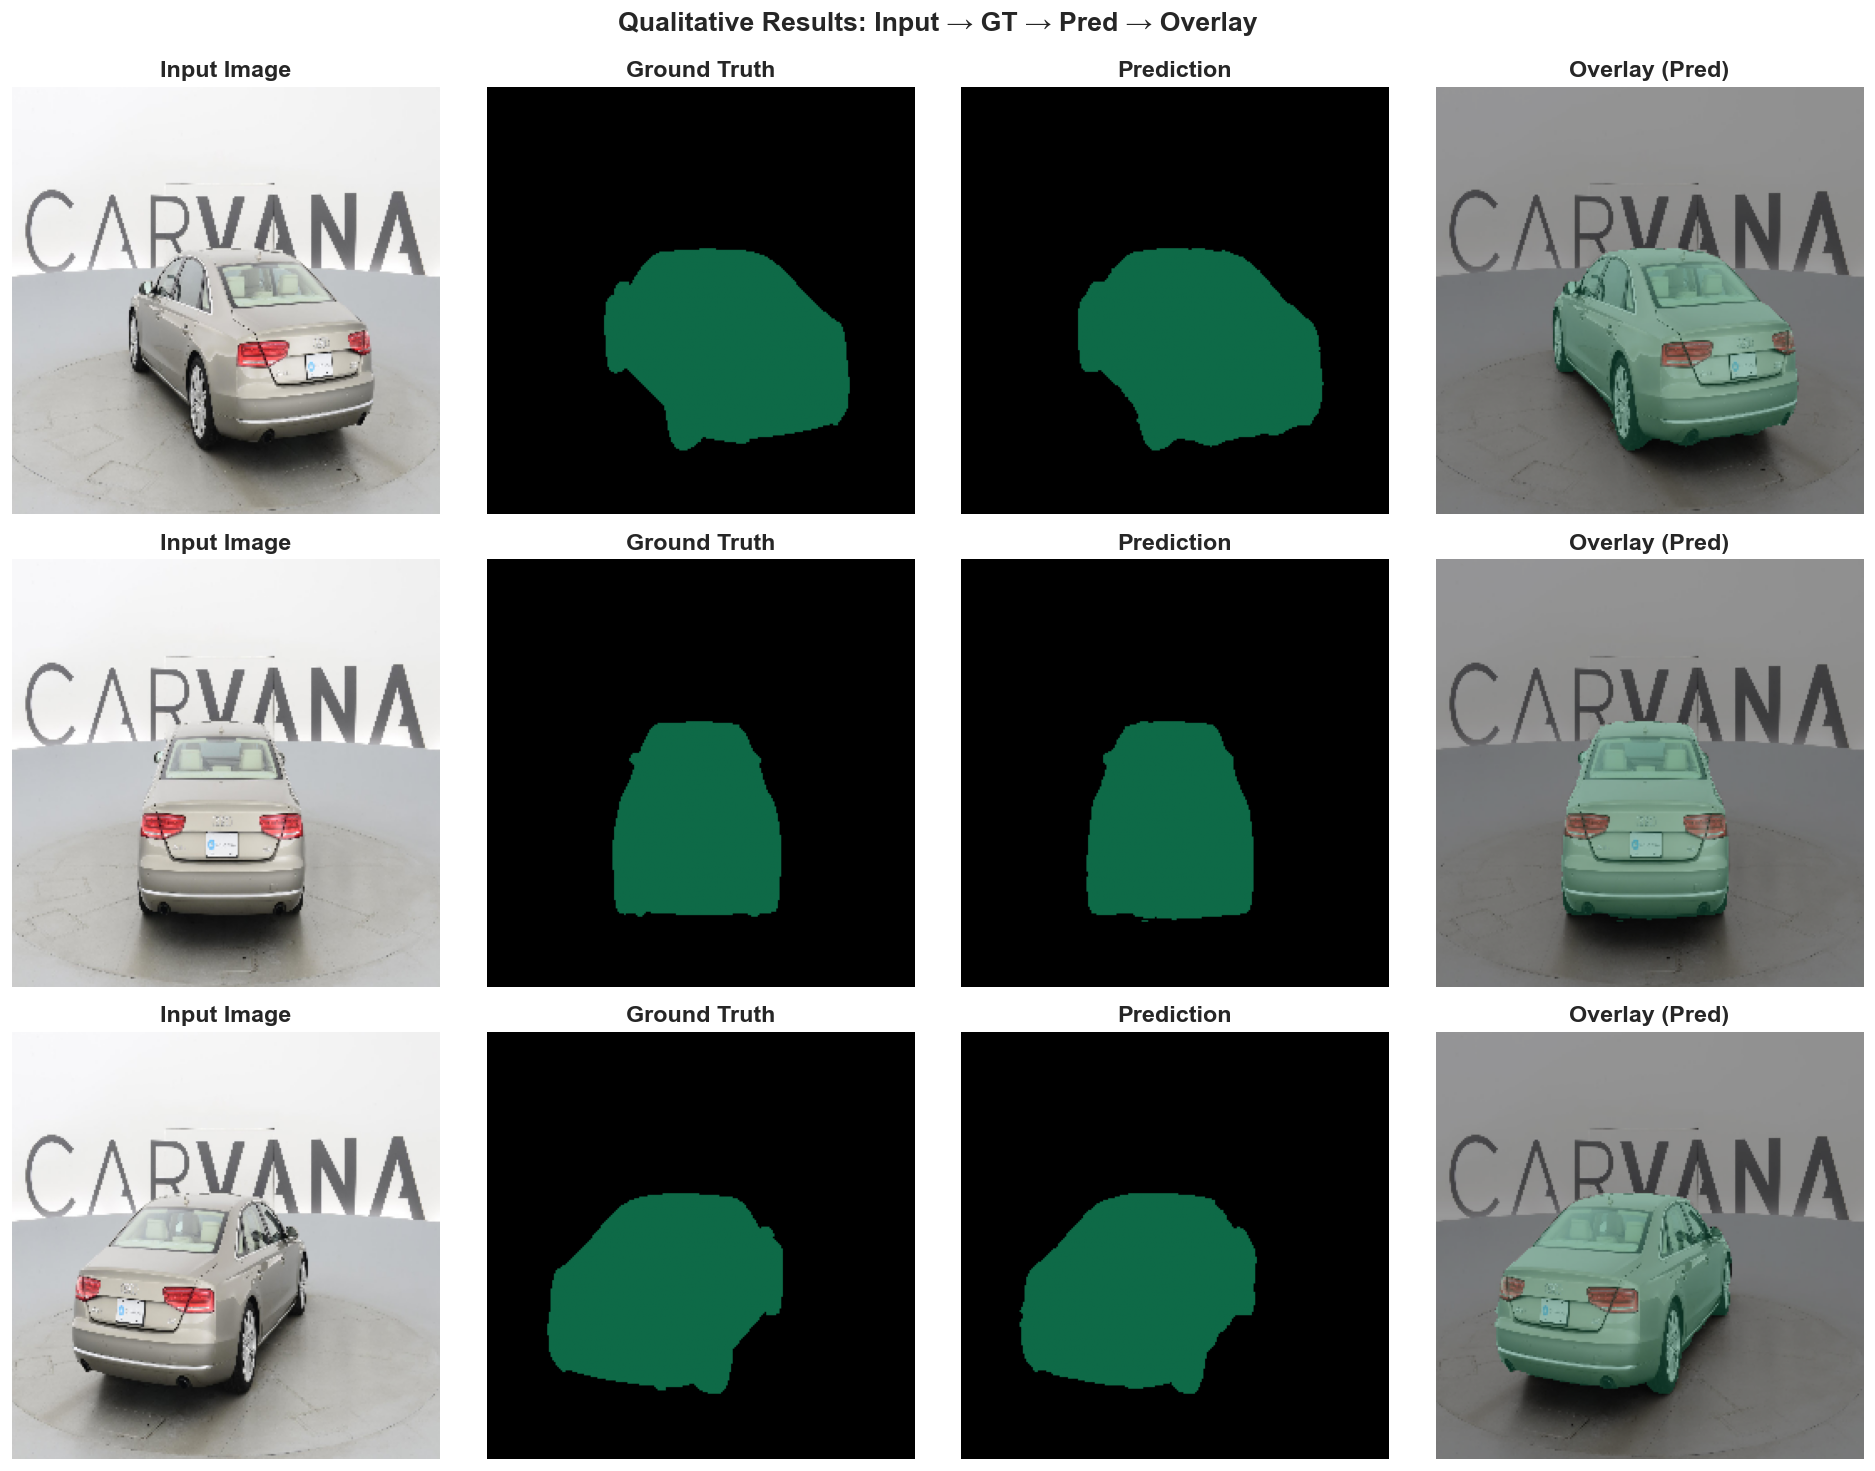

In [39]:
# Для Cityscapes (пример имен классов)
cityscapes_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle', 'void'
]

# Запуск
visualize_predictions(model, val_loader, device, class_names=cityscapes_classes[:NUM_CLASSES], num_samples=3)

In [41]:
import pandas as pd

def create_metrics_table(history, best_epoch_idx=None):
    df = pd.DataFrame({
        'Epoch': list(range(1, len(history['train_loss']) + 1)),
        'Train Loss': [f"{x:.4f}" for x in history['train_loss']],
        'Val Loss': [f"{x:.4f}" for x in history['val_loss']],
        'Val IoU': [f"{x:.4f}" for x in history['val_iou']],
        'Val Dice': [f"{x:.4f}" for x in history['val_dice']],
        'Val Acc': [f"{x:.4f}" for x in history['val_acc']],
    })
    
    if best_epoch_idx is not None:
        best_row = df.iloc[best_epoch_idx]
        print("🏆 Best Model (Val IoU):")
        print(f"  Epoch: {best_row['Epoch']}")
        print(f"  Val IoU: {best_row['Val IoU']}, Val Dice: {best_row['Val Dice']}, Val Acc: {best_row['Val Acc']}")
        print()
    
    # Стилизация таблицы
    styled = df.style\
        .set_caption("Таблица 1: Метрики модели UNet по эпохам")\
        .format(precision=4)\
        .highlight_max(subset=['Val IoU', 'Val Dice', 'Val Acc'], color='lightgreen')\
        .highlight_min(subset=['Val Loss'], color='lightcoral')\
        .set_table_styles([
            {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]},
        ])
    
    return styled

# Пример:
best_epoch_idx = np.argmax(history['val_iou'])  # 0-based
display(create_metrics_table(history, best_epoch_idx))

🏆 Best Model (Val IoU):
  Epoch: 7
  Val IoU: 0.9987, Val Dice: 0.9993, Val Acc: 0.9956



,Epoch,Train Loss,Val Loss,Val IoU,Val Dice,Val Acc
0,1,0.0366,0.0249,0.9971,0.9985,0.9902
1,2,0.0228,0.0161,0.9982,0.9991,0.9937
2,3,0.0177,0.0543,0.9950,0.9974,0.9819
3,4,0.0187,0.0134,0.9985,0.9992,0.9948
4,5,0.0161,0.0134,0.9984,0.9992,0.9947
5,6,0.0157,0.0152,0.9983,0.9991,0.9942
6,7,0.0145,0.0108,0.9987,0.9993,0.9956
7,8,0.0122,0.0816,0.9920,0.9957,0.9697
8,9,0.0131,0.0107,0.9987,0.9993,0.9956
9,10,0.0132,0.0109,0.9986,0.9993,0.9954


# Эксперимент изменение размера входных изображений

In [46]:
NUM_EPOCHS_EXP = 10
IMG_SIZE_EXP = 64

In [47]:
# Создание датасетов меньшего размера
train_dataset_small = CarvanaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_files, transform=A.Compose([
    A.Resize(IMG_SIZE_EXP, IMG_SIZE_EXP),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
]))

val_dataset_small = CarvanaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, val_files, transform=A.Compose([
    A.Resize(IMG_SIZE_EXP, IMG_SIZE_EXP),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
]))

train_loader_small = DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_small = DataLoader(val_dataset_small, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Создание новой модели
model_small = UNet(in_channels=3, num_classes=NUM_CLASSES).to(device)
criterion_small = nn.CrossEntropyLoss()
optimizer_small = optim.Adam(model_small.parameters(), lr=LEARNING_RATE)

# История для маленькой модели
history_small = {'train_iou': [], 'val_iou': [], 'train_dice': [], 'val_dice': []}

# Обучение
for epoch in range(NUM_EPOCHS_EXP):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS_EXP}', end=' - ')
    
    train_loss, train_iou, train_dice, _ = train_epoch(
        model_small, train_loader_small, criterion_small, optimizer_small, device
    )
    val_loss, val_iou, val_dice, _ = validate(
        model_small, val_loader_small, criterion_small, device
    )
    
    history_small['train_iou'].append(train_iou)
    history_small['val_iou'].append(val_iou)
    history_small['train_dice'].append(train_dice)
    history_small['val_dice'].append(val_dice)
    
    print(f'Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}')

print(f"\nРезультаты эксперимента:")
print(f"  Размер 256x256: Val IoU = {max(history['val_iou']):.4f}, Val Dice = {max(history['val_dice']):.4f}")
print(f"  Размер 64x64: Val IoU = {max(history_small['val_iou']):.4f}, Val Dice = {max(history_small['val_dice']):.4f}")
print("=" * 60)

Epoch 1/10 - 

Валидация: 100%|██████████| 255/255 [00:38<00:00,  6.62it/s]


Val IoU: 0.9954, Val Dice: 0.9976
Epoch 2/10 - 

Валидация: 100%|██████████| 255/255 [00:40<00:00,  6.35it/s]


Val IoU: 0.9960, Val Dice: 0.9979
Epoch 3/10 - 

Валидация: 100%|██████████| 255/255 [00:40<00:00,  6.32it/s]


Val IoU: 0.9959, Val Dice: 0.9979
Epoch 4/10 - 

Валидация: 100%|██████████| 255/255 [00:40<00:00,  6.31it/s]


Val IoU: 0.9968, Val Dice: 0.9984
Epoch 5/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.41it/s]


Val IoU: 0.9968, Val Dice: 0.9984
Epoch 6/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.41it/s]


Val IoU: 0.9971, Val Dice: 0.9985
Epoch 7/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.38it/s]


Val IoU: 0.9971, Val Dice: 0.9985
Epoch 8/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.43it/s]


Val IoU: 0.9972, Val Dice: 0.9986
Epoch 9/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.44it/s]


Val IoU: 0.9976, Val Dice: 0.9988
Epoch 10/10 - 

Валидация: 100%|██████████| 255/255 [00:39<00:00,  6.43it/s]

Val IoU: 0.9975, Val Dice: 0.9987

Результаты эксперимента:
  Размер 256x256: Val IoU = 0.9987, Val Dice = 0.9993
  Размер 64x64: Val IoU = 0.9976, Val Dice = 0.9988


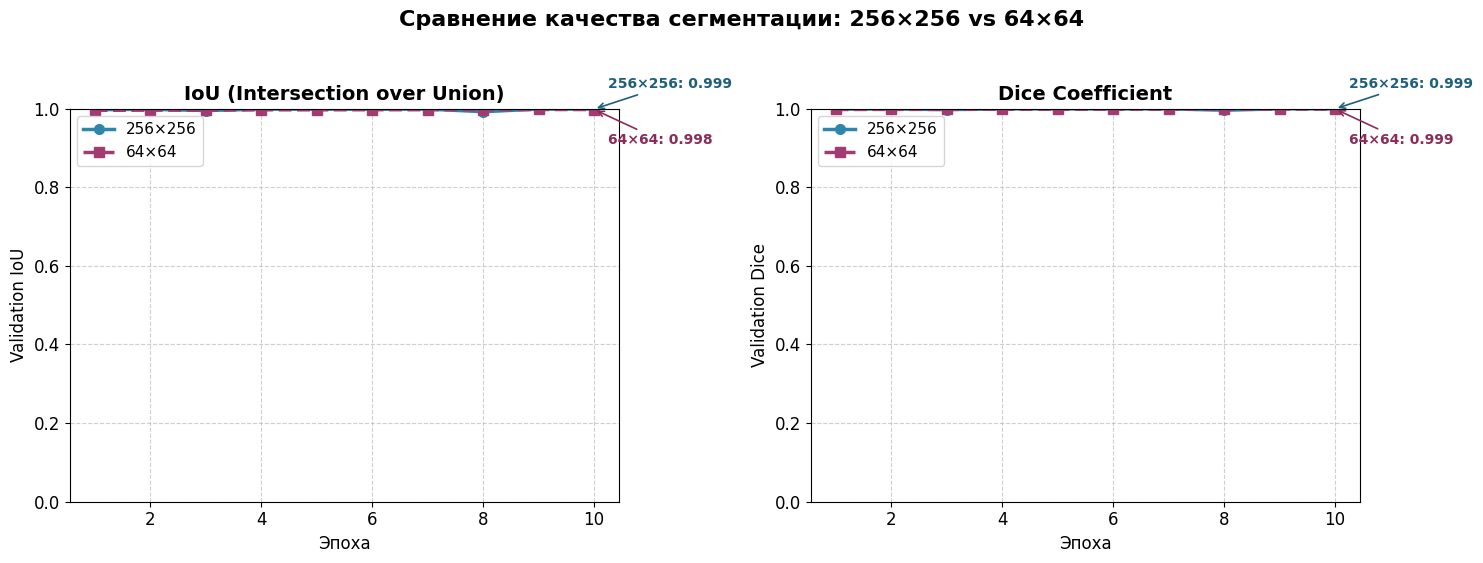


 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА: Влияние разрешения изображения на качество  
Метрика 256×256  64×64 Δ (абс.) Δ (%)
    IoU  0.9987 0.9976  +0.0011 +0.1%
   Dice  0.9993 0.9988  +0.0006 +0.1%

📌 Вывод:
• Разница в качестве незначительна (+0.001 IoU)
• Даже при 64×64 модель показывает хорошее качество (IoU = 0.998)
• Оптимальный выбор зависит от задачи: скорость (64×64) vs точность (256×256)


In [49]:

# Настройка стиля "вручную"
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# Обрезаем историю большой модели до NUM_EPOCHS_EXP, если она длиннее
val_iou_big = history['val_iou'][:NUM_EPOCHS_EXP]
val_dice_big = history['val_dice'][:NUM_EPOCHS_EXP]

epochs = np.arange(1, NUM_EPOCHS_EXP + 1)

# Вычисляем лучшие значения
best_iou_big = max(val_iou_big)
best_iou_small = max(history_small['val_iou'])
best_dice_big = max(val_dice_big)
best_dice_small = max(history_small['val_dice'])

# ==========================
# 1. Графики сравнения
# ==========================
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))
fig.suptitle('Сравнение качества сегментации: 256×256 vs 64×64', 
             fontsize=16, fontweight='bold', y=1.02)

# --- IoU ---
axes[0].plot(epochs, val_iou_big, 'o-', 
             color='#2E86AB', linewidth=2.5, markersize=7, label='256×256')
axes[0].plot(epochs, history_small['val_iou'], 's--', 
             color='#A23B72', linewidth=2.5, markersize=7, label='64×64')

axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Validation IoU')
axes[0].set_ylim(0, 1)
axes[0].legend(frameon=True, fontsize=11)
axes[0].grid(True)
axes[0].set_title('IoU (Intersection over Union)', fontweight='bold')

# --- Dice ---
axes[1].plot(epochs, val_dice_big, 'o-', 
             color='#2E86AB', linewidth=2.5, markersize=7, label='256×256')
axes[1].plot(epochs, history_small['val_dice'], 's--', 
             color='#A23B72', linewidth=2.5, markersize=7, label='64×64')

axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Validation Dice')
axes[1].set_ylim(0, 1)
axes[1].legend(frameon=True, fontsize=11)
axes[1].grid(True)
axes[1].set_title('Dice Coefficient', fontweight='bold')

# Добавляем аннотации с лучшими значениями
for ax, big_val, small_val in zip(axes, [best_iou_big, best_dice_big], [best_iou_small, best_dice_small]):
    ax.annotate(f'256×256: {big_val:.3f}', 
                xy=(epochs[-1], big_val), 
                xytext=(10, 15), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='#1E5F7C', lw=1.2),
                fontsize=10, fontweight='bold', color='#1E5F7C')
    
    ax.annotate(f'64×64: {small_val:.3f}', 
                xy=(epochs[-1], small_val), 
                xytext=(10, -25), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='#8B2C5A', lw=1.2),
                fontsize=10, fontweight='bold', color='#8B2C5A')

plt.tight_layout()
plt.show()

# ==========================
# 2. Таблица сравнения
# ==========================
delta_iou = best_iou_big - best_iou_small
delta_dice = best_dice_big - best_dice_small

data = {
    'Метрика': ['IoU', 'Dice'],
    '256×256': [f"{best_iou_big:.4f}", f"{best_dice_big:.4f}"],
    '64×64': [f"{best_iou_small:.4f}", f"{best_dice_small:.4f}"],
    'Δ (абс.)': [f"{delta_iou:+.4f}", f"{delta_dice:+.4f}"],
    'Δ (%)': [
        f"{delta_iou / best_iou_small * 100:+.1f}%" if best_iou_small > 1e-6 else "–",
        f"{delta_dice / best_dice_small * 100:+.1f}%" if best_dice_small > 1e-6 else "–"
    ]
}

df = pd.DataFrame(data)
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА: Влияние разрешения изображения на качество".center(70))
print("="*70)
print(df.to_string(index=False, float_format="{:.4f}".format))
print("="*70)

print(f"\n📌 Вывод:")
if delta_iou > 0.05:
    print(f"• Разрешение 256×256 даёт **значительно лучшее** качество (+{delta_iou:.3f} IoU)")
elif delta_iou > 0.01:
    print(f"• Разрешение 256×256 даёт **заметно лучшее** качество (+{delta_iou:.3f} IoU)")
else:
    print(f"• Разница в качестве незначительна ({delta_iou:+.3f} IoU)")

if best_iou_small > 0.7:
    print(f"• Даже при 64×64 модель показывает хорошее качество (IoU = {best_iou_small:.3f})")
else:
    print(f"• Низкое разрешение (64×64) приводит к потере деталей (IoU < 0.70)")

print(f"• Оптимальный выбор зависит от задачи: скорость (64×64) vs точность (256×256)")